<a href="https://colab.research.google.com/github/HKLeeeee/Studying_Algorithm/blob/main/%5Bpycaret%5Danalytics_model_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=5829ba1ee597234207aa1c01717fcdbfd505dfa57f9ff6a208dbb912d804cb37
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 5.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [ ]:
!pip install pycaret

<font color='red'>런타임 재실행</font>

In [3]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [4]:
!pip install markupsafe==2.0.1
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 356 kB 5.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491679 sha256=91e3d6b387ecfefb40e65c0695b24a1dfae70c4356b4363f2c0e65b86ba32f87
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [3]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 


# Import

In [4]:
import pymysql
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import classification_report
import os
from time import time
from pycaret.classification import *
from pycaret.utils import check_metric
import shap

# Load Data

In [17]:
endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema_name = 'storage'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema_name )
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

def load_data_from_rds(tabel_name):
  sql = "SELECT * FROM {}".format(tabel_name)
  df = pd.read_sql(sql, db_connection)
  return df

data_list = {}
data_list['overpass'] = load_data_from_rds('MainData_overpass')
data_list['tunnel'] = load_data_from_rds('MainData_tunnel')

# Define func

In [46]:
def pycaret_setup(data_set, target_idx: str, random_seed, is_tunnel=False) :
    print(random_seed)
    numeric=['width', 'length', 'dist_walkway', 'dist_farm', 'frequency_appearance_animals',
          'dist_river', 'dist_hikingtrails', 'fence_length', 'fence_height', 'traffic_volume', 'dist_buildings',
          'speed_limit', 'num_lane']
    ordinal_col = {'soilslope' : ['7', '6', '5', '4', '3', '2', '1'],
               'environmental_score' : ['5', '4', '3', '2', '1'],
               'frequency_use_hikers' : ['5', '4', '3', '2', '1', '0']}
    if is_tunnel :
      numeric += ['height', 'openness']
    clf = setup(data=data_set, target=str(target_idx), train_size=0.8, 
                fix_imbalance=True, use_gpu=True, feature_selection=True, 
                remove_multicollinearity=True, multicollinearity_threshold=0.5,
                numeric_features=numeric,
                categorical_features=['topography', 'vegetation'],
                session_id=random_seed, normalize=True)

In [19]:
def preprocess_df(df, onehot_col=None) :
    if onehot_col is not None:
        df = pd.get_dummies(df, columns=onehot_col)
    return df

In [20]:
# target_name : test 데이터의 목표변수 컬럼명
def predictModel(train_model, test_set, target_name): 
   pred = predict_model(train_model, data = test_set, verbose=False)
   print("개선율: "+str(check_metric(pred['Label'], test_set[target_name], metric = 'Accuracy')))

In [45]:
scaling_col_overpass = ['width', 'length', 'dist_walkway', 'dist_farm', 'speed_limit', 'frequency_appearance_animals',
                        'dist_river', 'dist_hikingtrails', 'fence_length', 'fence_height', 'traffic_volume', 'dist_buildings',
                        'num_lane']
scaling_col_tunnel = scaling_col_overpass + ['height', 'openness']

In [22]:
onehot_col = ['frequency_use_hikers', 'soilslope', 'topography', 'environmental_score', 'vegetation']

In [23]:
df_overpass = preprocess_df(data_list['overpass'], onehot_col)
df_tunnel = preprocess_df(data_list['tunnel'], onehot_col)

# Overpass

In [26]:
data_set = data_list['overpass']

data_set = data_set.drop('num_near_species', axis=1)

# setup pycaret session
pycaret_setup(data_set, 'efficiency', is_tunnel=False, random_seed = 5)

,Description,Value
0,session_id,5
1,Target,efficiency
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(300, 19)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['topography',
                                                            'vegetation'],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['width', 'length',
                                                          'dist_walkway',
                                                          'dist_farm',
                                                          'frequency_appearance_animals',
                                                          'dist_river',
                                                          'dist_hikingtrails',
                            

## Find Best Model

In [27]:
compare_models(round = 3, sort = 'F1', errors="raise")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.629,0.687,0.643,0.648,0.643,0.255,0.257,0.062
lr,Logistic Regression,0.583,0.591,0.615,0.608,0.609,0.165,0.166,0.037
lda,Linear Discriminant Analysis,0.575,0.595,0.615,0.596,0.602,0.148,0.149,0.026
ridge,Ridge Classifier,0.575,0.000,0.607,0.597,0.599,0.148,0.149,0.051
rf,Random Forest Classifier,0.567,0.617,0.608,0.588,0.593,0.129,0.132,1.027
gbc,Gradient Boosting Classifier,0.600,0.654,0.575,0.627,0.591,0.203,0.206,0.158
knn,K Neighbors Classifier,0.579,0.622,0.566,0.610,0.583,0.160,0.162,0.217
ada,Ada Boost Classifier,0.542,0.589,0.569,0.567,0.567,0.082,0.082,0.151
dt,Decision Tree Classifier,0.567,0.569,0.546,0.590,0.564,0.139,0.138,0.029
et,Extra Trees Classifier,0.538,0.572,0.576,0.563,0.563,0.073,0.074,1.008


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## model 생성 및 학습

In [28]:
overpass_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5833,0.7188,0.5833,0.5833,0.5833,0.1667,0.1667
1,0.6250,0.6285,0.5833,0.6364,0.6087,0.2500,0.2509
2,0.6667,0.6632,0.8333,0.6250,0.7143,0.3333,0.3536
3,0.5417,0.6189,0.5385,0.5833,0.5600,0.0833,0.0836
4,0.5833,0.6783,0.4615,0.6667,0.5455,0.1837,0.1943
5,0.3750,0.4336,0.3846,0.4167,0.4000,-0.2500,-0.2509
6,0.7500,0.8357,0.8462,0.7333,0.7857,0.4894,0.4966
7,0.5000,0.4510,0.6923,0.5294,0.6000,-0.0360,-0.0383
8,0.4167,0.4301,0.4615,0.4615,0.4615,-0.1748,-0.1748


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


## plot result

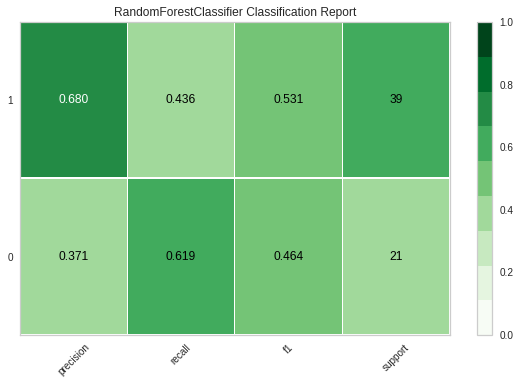

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [29]:
plot_model(overpass_rf, plot='class_report', plot_kwargs={'cmap':'Greens'}, use_train_data=False)

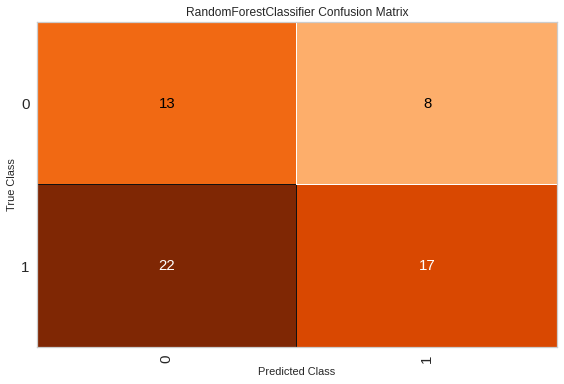

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [30]:
plot_model(overpass_rf, plot='confusion_matrix', plot_kwargs={'cmap':'Oranges'}, use_train_data=False)

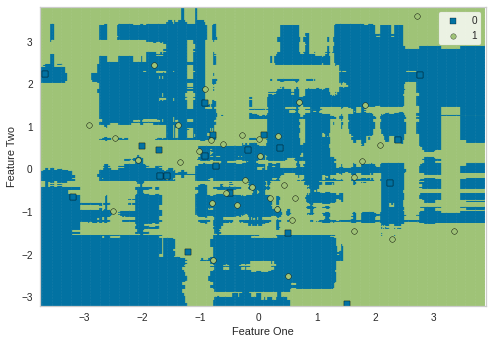

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [31]:
plot_model(overpass_rf, plot='boundary')

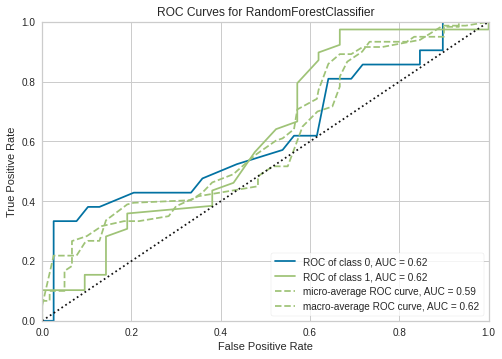

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [32]:
plot_model(overpass_rf, plot='auc')

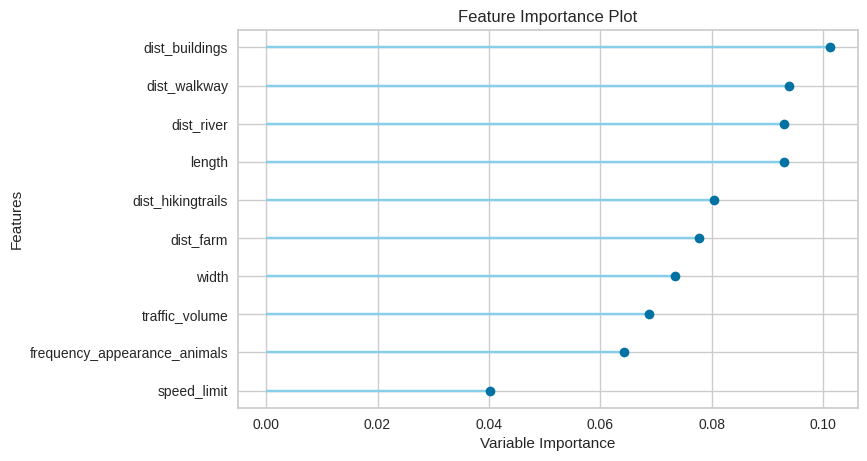

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [33]:
plot_model(overpass_rf, plot='feature')

In [34]:
fi_df = pd.DataFrame({'Feature': get_config('X_train').columns, 
              'Value' : overpass_rf.feature_importances_}).sort_values(by='Value', ascending=False)
             # 'Value' : overpass_rf.coef_[0, :]}).sort_values(by='Value', ascending=False)
feature_top10 = fi_df['Feature'][:10].to_list()
# feature_top10

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_train)
INFO:logs:Global variable: X_train returned as      topography_해안    length     width  frequency_use_hikers_5  dist_river  \
102            0.0  0.237392  0.021314                     0.0   -1.348958   
108            0.0  0.030582 -0.087294                     0.0   -1.248294   
96             0.0 -0.062239 -0.358815                     0.0    0.391962   
294            1.0 -0.931819 -0.680114                     0.0    2.457811   
11             0.0 -0.868311  0.356189                     0.0   -0.702465   
..             ...       ...       ...                     ...         ...   
8              0.0 -1.395922  0.496475                     1.0   -0.232793   
73             0.0  0.289502 -0.634861                     0.0   -1.257069   
118            0.0  2.385290 -0.100871                     0.0    0.089179   
189            0.0 -0.345585  2.464999                     0.0    1.003975   
206            0.0 -

## Inference

In [35]:
inference_data_set = data_set[data_set['efficiency']==0]
inference_data_set['efficiency'] = 1

predictModel(overpass_rf, inference_data_set, 'efficiency')

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0597


In [36]:
for i,idx in enumerate(feature_top10) :
  mono = data_set[data_set['efficiency']==0]
  mono['efficiency'] = 1
  
  try : 
    amount = data_set.groupby('efficiency')[idx].mean()
  except :
    idx = '_'.join(idx.split('_')[:-1])
    feature_top10[i] = idx
    amount = data_set.groupby('efficiency')[idx].mean()
  diff= amount[0]-amount[1]
  mono[idx] = mono[idx] - diff
  print('***** {} ***** '.format(idx))
  predictModel(overpass_rf, mono, 'efficiency')
  inference_data_set[idx] = inference_data_set[idx] - diff

print('**********Change All********')
predictModel(overpass_rf, inference_data_set, 'efficiency')

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


***** dist_buildings ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0672
***** dist_walkway ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0597
***** dist_river ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0672
***** length ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0597
***** dist_hikingtrails ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0597
***** dist_farm ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0597
***** width ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0522
***** traffic_volume ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0597
***** frequency_appearance_animals ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0522
***** speed_limit ***** 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0597
**********Change All********
개선율: 0.1194


In [37]:
overpass_insight = data_set.groupby('efficiency')[feature_top10].mean()
overpass_insight = overpass_insight.T
overpass_insight = pd.DataFrame(overpass_insight)
overpass_insight.columns = ['0', '1']
overpass_insight['feature importances values'] = fi_df['Value'][:10].to_list()
overpass_insight.index = feature_top10
overpass_insight.index.name='Feature Name'
overpass_insight = overpass_insight[['feature importances values','0', '1']]
overpass_insight

,feature importances values,0,1
Feature Name,,,
dist_buildings,0.101165,0.167342,0.213928
dist_walkway,0.093817,154.151527,159.208464
dist_river,0.093045,1180.741912,1116.978298
length,0.092954,40.634701,38.230582
dist_hikingtrails,0.080455,1.931152,1.651438
dist_farm,0.077749,0.103138,0.105341
width,0.073425,28.740050,30.180703
traffic_volume,0.068813,23962.270326,27001.828287
frequency_appearance_animals,0.064180,5.703980,5.136546


INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False), use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


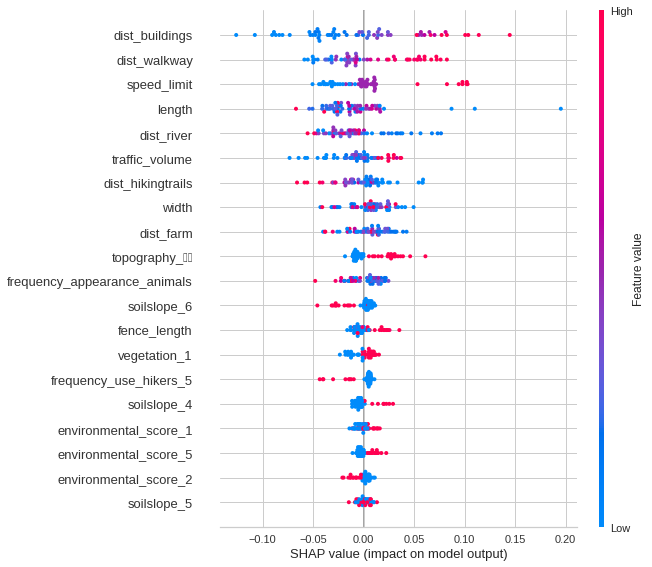

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [38]:
interpret_model(overpass_rf)

# Tunnel

In [48]:
data_set = data_list['tunnel']

data_set = data_set.drop('num_near_species', axis=1)

# setup pycaret session
pycaret_setup(data_set, 'efficiency', is_tunnel=True, random_seed=337)

,Description,Value
0,session_id,337
1,Target,efficiency
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(197, 21)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['topography',
                                                            'vegetation'],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['width', 'length',
                                                          'dist_walkway',
                                                          'dist_farm',
                                                          'frequency_appearance_animals',
                                                          'dist_river',
                                                          'dist_hikingtrails',
                            

## Find Best Model

In [49]:
compare_models(round = 3, sort = 'F1', errors="raise")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.744,0.815,0.778,0.802,0.787,0.463,0.468,0.052
rf,Random Forest Classifier,0.744,0.824,0.768,0.803,0.782,0.470,0.476,1.089
gbc,Gradient Boosting Classifier,0.738,0.840,0.768,0.801,0.781,0.451,0.457,0.138
ada,Ada Boost Classifier,0.731,0.769,0.776,0.798,0.778,0.427,0.436,0.133
et,Extra Trees Classifier,0.701,0.777,0.801,0.732,0.762,0.360,0.368,1.229
dt,Decision Tree Classifier,0.694,0.673,0.769,0.746,0.751,0.347,0.358,0.026
lr,Logistic Regression,0.636,0.718,0.661,0.717,0.684,0.250,0.254,0.034
lda,Linear Discriminant Analysis,0.623,0.684,0.650,0.706,0.674,0.225,0.230,0.026
ridge,Ridge Classifier,0.629,0.000,0.639,0.719,0.673,0.242,0.249,0.038
knn,K Neighbors Classifier,0.664,0.749,0.592,0.809,0.672,0.346,0.371,0.180


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=337, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=337, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## model 생성 및 학습

In [50]:
tunnel_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.8000,0.7000,0.8750,0.7778,0.5000,0.5164
1,0.8125,0.8833,0.9000,0.8182,0.8571,0.5862,0.5919
2,0.8125,0.7833,0.8000,0.8889,0.8421,0.6129,0.6181
3,0.6875,0.7667,0.8000,0.7273,0.7619,0.3103,0.3133
4,0.7500,0.7333,0.7000,0.8750,0.7778,0.5000,0.5164
5,0.8750,0.9365,0.8889,0.8889,0.8889,0.7460,0.7460
6,0.6875,0.8968,0.6667,0.7500,0.7059,0.3750,0.3780
7,0.7333,0.8519,0.7778,0.7778,0.7778,0.4444,0.4444
8,0.8000,0.8148,0.8889,0.8000,0.8421,0.5714,0.5774


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


## plot result

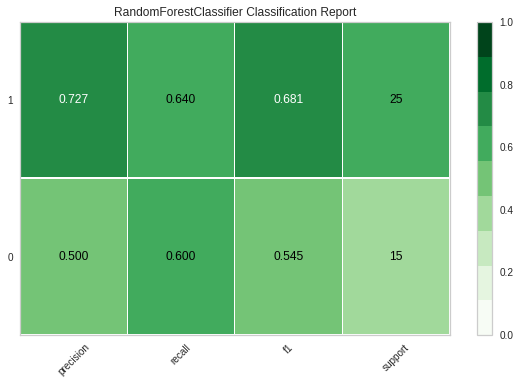

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [52]:
plot_model(tunnel_rf, plot='class_report', plot_kwargs={'cmap':'Greens'}, use_train_data=False)

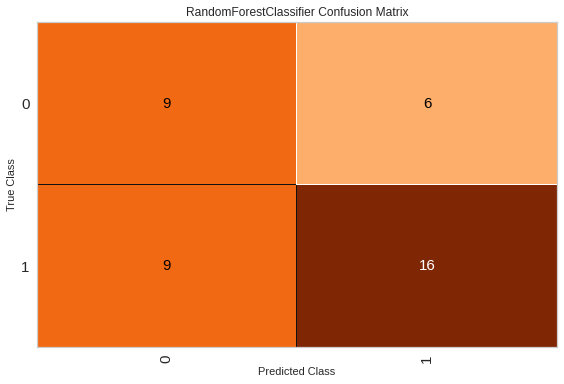

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [53]:
plot_model(tunnel_rf, plot='confusion_matrix', plot_kwargs={'cmap':'Oranges'})

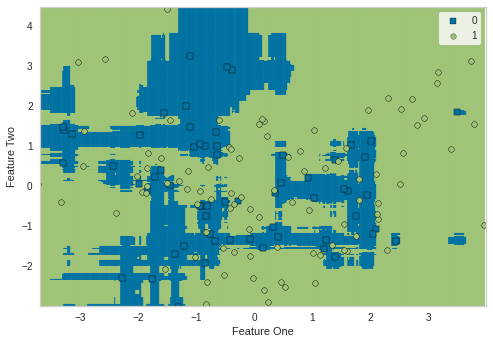

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [54]:
plot_model(tunnel_rf, plot='boundary', use_train_data=True)

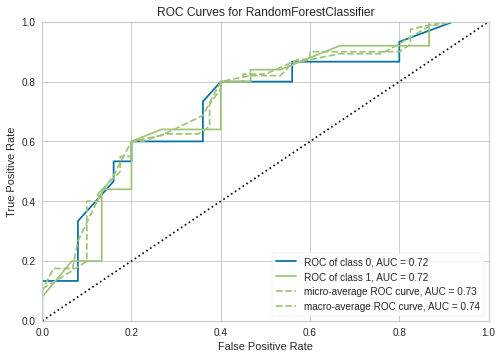

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [55]:
plot_model(tunnel_rf, plot='auc')

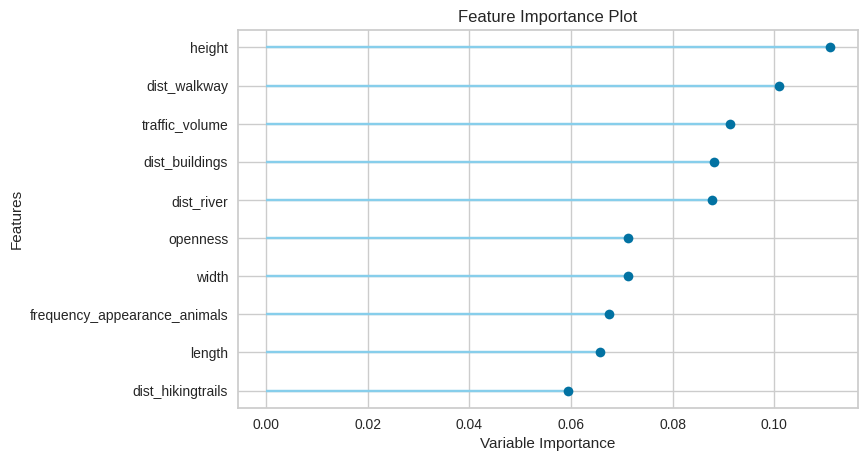

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [56]:
plot_model(tunnel_rf, plot='feature')

In [60]:
fi_df = pd.DataFrame({'Feature': get_config('X_train').columns, 
                      'Value' : tunnel_rf.feature_importances_}).sort_values(by='Value', ascending=False)
             #       'Value' : tunnel_rf.coef_[0, :]}).sort_values(by='Value', ascending=False)
feature_top10 = fi_df['Feature'][:10].to_list()
feature_top10

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_train)
INFO:logs:Global variable: X_train returned as        length     width  frequency_use_hikers_5  dist_river  \
61   1.446867  0.384766                     0.0    0.638637   
127  0.470772  0.051894                     0.0   -0.655468   
44   0.552365  0.701787                     0.0    0.688412   
19  -1.109716  0.012267                     0.0   -1.010767   
65  -0.166863 -0.701029                     0.0   -0.173075   
..        ...       ...                     ...         ...   
63   1.247417 -1.216188                     0.0   -0.731344   
187 -0.499279 -0.066988                     0.0    1.808831   
185 -0.499279 -0.066988                     0.0    0.717947   
66   0.135334  0.662159                     0.0    0.404905   
4   -1.236639  0.899925                     0.0   -0.723245   

     environmental_score_4  dist_hikingtrails  topography_하천  traffic_volume  \
61                     0.0           0.08

['height',
 'dist_walkway',
 'traffic_volume',
 'dist_buildings',
 'dist_river',
 'openness',
 'width',
 'frequency_appearance_animals',
 'length',
 'dist_hikingtrails']

## Inference

In [61]:
inference_data_set = data_set[data_set['efficiency']==0]
inference_data_set['efficiency'] = 1

predictModel(tunnel_rf, inference_data_set, 'efficiency')

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779


In [62]:
for i,idx in enumerate(feature_top10) :
  mono = data_set[data_set['efficiency']==0]
  mono['efficiency'] = 1
  
  try : 
    amount = data_set.groupby('efficiency')[idx].mean()
  except :
    idx = '_'.join(idx.split('_')[:-1])
    #feature_top10[i] = idx
    amount = data_set.groupby('efficiency')[idx].mean()
  diff= amount[0]-amount[1]
  mono[idx] = mono[idx] - diff

  inference_data_set[idx] = inference_data_set[idx] - diff

  print('********* {} ********* '.format(idx))
  predictModel(tunnel_rf, mono, 'efficiency')


print('**********Change All********')
predictModel(tunnel_rf, inference_data_set, 'efficiency')

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


********* height ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779
********* dist_walkway ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779
********* traffic_volume ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0649
********* dist_buildings ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779
********* dist_river ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0519
********* openness ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779
********* width ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779
********* frequency_appearance_animals ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779
********* length ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779
********* dist_hikingtrails ********* 


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=False, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


개선율: 0.0779
**********Change All********
개선율: 0.3117


INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=337, verbose=0,
                       warm_start=False), use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


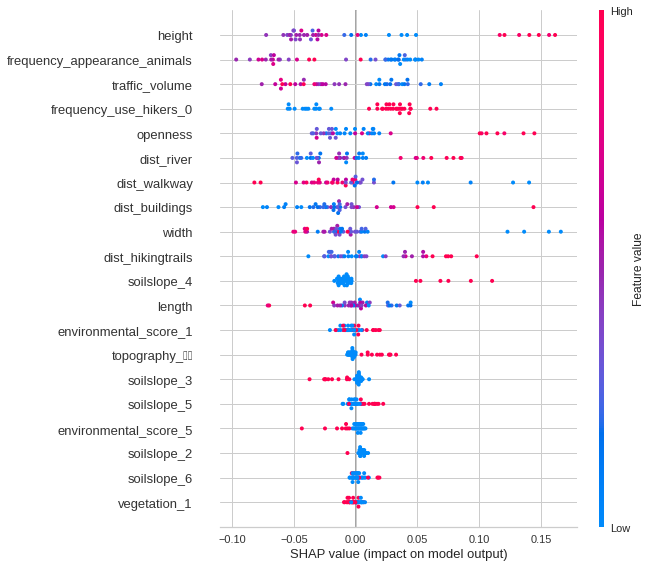

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [63]:
interpret_model(tunnel_rf)

In [64]:
tunnel_insight = df_tunnel.groupby('efficiency')[feature_top10].mean().to_numpy()
tunnel_insight = tunnel_insight.T
tunnel_insight = pd.DataFrame(tunnel_insight, columns=['효율성 낮음 평균', '효율성 높음 평균'])
tunnel_insight['feature_importances values'] = fi_df['Value'][:10].to_list()
tunnel_insight.index = feature_top10
tunnel_insight.index.name='Feature Name'
tunnel_insight = tunnel_insight[['feature_importances values','효율성 낮음 평균', '효율성 높음 평균']]
tunnel_insight

,feature_importances values,효율성 낮음 평균,효율성 높음 평균
Feature Name,,,
height,0.110935,2.668398,2.808333
dist_walkway,0.100923,173.375065,133.651599
traffic_volume,0.091269,12555.955479,9813.621133
dist_buildings,0.088065,0.181612,0.270442
dist_river,0.087754,849.622239,1303.432162
openness,0.071322,12.425541,17.405556
width,0.071235,6.754978,6.806944
frequency_appearance_animals,0.067529,8.220779,7.555556
length,0.065715,29.037229,29.296389
